In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold
from sklearn.metrics import precision_recall_curve, precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

In [23]:
initial_data = pd.read_csv('UNSW_NB15_training-set-modified.csv')

In [24]:
data_to_use = initial_data.dropna()

In [25]:
data_to_use.shape

(175341, 41)

In [26]:
X = data_to_use.drop(axis=1, columns=['attack_cat']) # X is a dataframe
X = X.drop(axis=1, columns=['label'])

y1 = data_to_use['attack_cat'].values # y is an array
y2 = data_to_use['label'].values

In [27]:
def data_ratio(y2):
    '''
    Calculate Y2's ratio
    '''
    unique, count = np.unique(y2, return_counts=True)
    ratio = round(count[0]/count[1], 1)
    return f'{ratio}:1 ({count[0]}/{count[1]})'

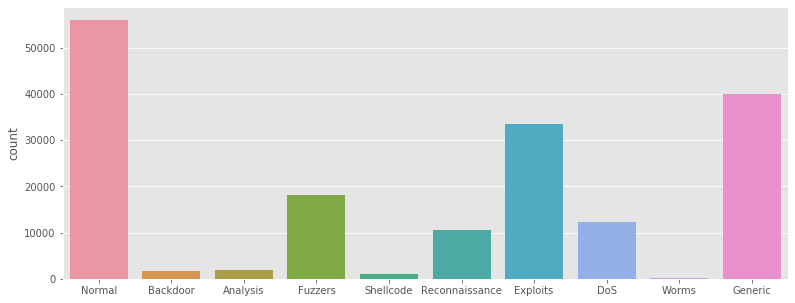

The class ratio for the original data: 0.5:1 (56000/119341)


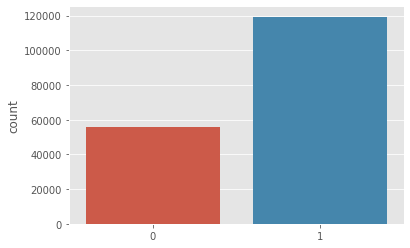

In [28]:
plt.figure(figsize=(13,5))
sns.countplot(y1,label="Sum")
plt.show()

print('The class ratio for the original data:', data_ratio(y2))
sns.countplot(y2,label="Sum")
plt.show()

In [29]:
test_data = pd.read_csv('UNSW_NB15_testing-set-modified.csv')
X_test = test_data.drop(axis=1, columns=['attack_cat']) # X_test is a dataframe
X_test = X_test.drop(axis=1, columns=['label'])

y1_test = test_data['attack_cat'].values # y is an array
y2_test = test_data['label'].values
X_train = X
y1_train = y1
y2_train = y2

In [30]:
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X_train.select_dtypes(include=['object', 'bool']).columns

In [31]:
numerical_cols

Index(['dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl',
       'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit',
       'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat', 'smean',
       'dmean', 'trans_depth', 'response_body_len', 'ct_srv_src',
       'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm',
       'ct_dst_src_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd',
       'ct_src_ltm', 'ct_srv_dst', 'is_sm_ips_ports'],
      dtype='object')

In [32]:
categorical_cols

Index([], dtype='object')

In [33]:
t = [('ohe', OneHotEncoder(drop='first'), categorical_cols),
    ('scale', StandardScaler(), numerical_cols)]

col_trans = ColumnTransformer(transformers=t)

col_trans.fit(X_train)

ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('ohe',
                                 OneHotEncoder(categories='auto', drop='first',
                                               dtype=<class 'numpy.float64'>,
                                               handle_unknown='error',
                                               sparse=True),
                                 Index([], dtype='object')),
                                ('scale',
                                 StandardScaler(copy=True, with_mean=True,
                                                with_std=True),
                                 Index(['dur', 'spkts', 'dpkts', 'sbytes...
       'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit',
       'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat', 'smean',
       'dmean', 'trans_depth', 'response_body_len', 'ct_srv_src',
       'ct_s

In [34]:
X_train_transform = col_trans.transform(X_train)

In [35]:
X_test_transform = col_trans.transform(X_test)

In [36]:
X_train_transform.shape

(175341, 39)

In [37]:
X_test_transform.shape

(82332, 39)

In [38]:
pd.unique(y1)

array(['Normal', 'Backdoor', 'Analysis', 'Fuzzers', 'Shellcode',
       'Reconnaissance', 'Exploits', 'DoS', 'Worms', 'Generic'],
      dtype=object)

In [39]:
target_trans = LabelEncoder()
target_trans.fit(y1_train)

LabelEncoder()

In [40]:
y1_train_transform = target_trans.transform(y1_train)
y1_test_transform = target_trans.transform(y1_test)

In [41]:
y1_train_transform

array([6, 6, 6, ..., 5, 5, 5])

In [42]:
clf = LogisticRegression(solver='lbfgs', random_state=123, max_iter = 4000, multi_class = "ovr")

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

scoring = ['accuracy', 'precision_micro', 'recall_micro', 'f1_micro', 'roc_auc_ovr']  

cv_results = cross_validate(estimator=clf,
                            X=X_train_transform,
                            y=y1_train_transform,
                            scoring=scoring,
                            cv=cv,
                            return_train_score=False) # prevent to show the train scores on cv splits.

In [43]:
cv_results

{'fit_time': array([123.87600827, 202.65023255, 140.01510358, 118.51406765,
        116.22041392]),
 'score_time': array([0.47701097, 0.59123421, 0.58822942, 0.33404875, 0.34530568]),
 'test_accuracy': array([0.73640537, 0.73833695, 0.74090339, 0.74150222, 0.73907836]),
 'test_precision_micro': array([0.73640537, 0.73833695, 0.74090339, 0.74150222, 0.73907836]),
 'test_recall_micro': array([0.73640537, 0.73833695, 0.74090339, 0.74150222, 0.73907836]),
 'test_f1_micro': array([0.73640537, 0.73833695, 0.74090339, 0.74150222, 0.73907836]),
 'test_roc_auc_ovr': array([0.93437272, 0.93130635, 0.93474159, 0.93328825, 0.93418042])}

In [44]:
cv_results['test_accuracy'].mean()

0.7392452583245565

In [45]:
clf.fit(X=X_train_transform, y=y1_train_transform)

y_pred_class = clf.predict(X=X_test_transform)
y_pred_score = clf.predict_proba(X=X_test_transform)[:, 1]


In [46]:
clf.fit(X=X_train_transform, y=y1_train_transform)


y_pred_class = clf.predict(X=X_test_transform)
y_pred_score = clf.predict_proba(X=X_test_transform)[:, 1]

cm_ontest = confusion_matrix(y_true=y1_test_transform, y_pred=y_pred_class)

precision_ontest = precision_score(y_true=y1_test_transform, y_pred=y_pred_class, average='micro')

recall_ontest = recall_score(y_true=y1_test_transform, y_pred=y_pred_class, average='micro')

cls_report_ontest = classification_report(y_true=y1_test_transform, y_pred=y_pred_class)


print('The precision score on the test set: {:1.5f}'.format(precision_ontest))
print('The recall score on the test set: {:1.5f}'.format(recall_ontest))
print('Confusion Matrix:\n', cm_ontest)

print('Classification Report:\n', cls_report_ontest)

The precision score on the test set: 0.63351
The recall score on the test set: 0.63351
Confusion Matrix:
 [[    0     0     5   190    24   189   267     2     0     0]
 [    0     0     5   104    44   189   221    20     0     0]
 [    0     0    61  3004   242   260   321   201     0     0]
 [   16     0    46  8446  1102   437   781   304     0     0]
 [    0     0    16   708  3181   403  1650   104     0     0]
 [    0     0     9  1427   222 16515   629    69     0     0]
 [  166     0    48  3702  9593   293 22349   831    18     0]
 [    0     0     6  1373   404    10    97  1606     0     0]
 [    0     0     0   125    92     0    14   147     0     0]
 [    0     0     0    23    13     6     1     1     0     0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       677
           1       0.00      0.00      0.00       583
           2       0.31      0.01      0.03      4089
           3       0.4

/home/jokera/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [60]:
models = [('LogisticRegression', LogisticRegression(random_state=123, max_iter=5000, multi_class = "ovr")),
#           ('DecisionTree', DecisionTreeClassifier(random_state=123)),
          ('RandomForest', RandomForestClassifier(random_state=123)),
          ('GradientBoosting', GradientBoostingClassifier(random_state=123))]
          #('MultiLayerPerceptron', MLPClassifier(random_state=123, solver='adam', max_iter=8000))
#             )]

In [61]:
for model_name, clf in models:
    print(clf)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=5000,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)
GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss

In [62]:
model_names_list = []
cv_fit_time_mean_list = []
cv_accuracy_mean_list = []
cv_precision_mean_list = []
cv_recall_mean_list = []
cv_f1_mean_list = []

test_accuracy_list = []
test_precision_list = []
test_recall_list = []
test_f1_list = []




for model_name, clf in models:
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

    scoring = ['accuracy', 'precision_micro', 'recall_micro', 'f1_micro']

    cv_results = cross_validate(estimator=clf,
                                X=X_train_transform,
                                y=y1_train_transform,
                                scoring=scoring,
                                cv=cv,
                                return_train_score=False)  


    cv_fit_time_mean = cv_results['fit_time'].mean()
    cv_accuracy_mean = cv_results['test_accuracy'].mean()
    cv_precision_mean = cv_results['test_precision_micro'].mean()
    cv_recall_mean = cv_results['test_recall_micro'].mean()
    cv_f1_mean = cv_results['test_f1_micro'].mean()


    model_names_list.append(model_name)
    cv_fit_time_mean_list.append(cv_fit_time_mean)
    cv_accuracy_mean_list.append(cv_accuracy_mean)
    cv_precision_mean_list.append(cv_precision_mean)
    cv_recall_mean_list.append(cv_recall_mean)
    cv_f1_mean_list.append(cv_f1_mean)

    clf.fit(X=X_train_transform, y=y1_train_transform)


    y_pred_class = clf.predict(X=X_test_transform)  
    
    y_pred_score = clf.predict_proba(X=X_test_transform)[:, 1]

    accuracy_ontest = accuracy_score(y_true=y1_test_transform, y_pred=y_pred_class)
    
    precision_ontest = precision_score(y_true=y1_test_transform, y_pred=y_pred_class, average = 'micro')
    
    recall_ontest = recall_score(y_true=y1_test_transform, y_pred=y_pred_class, average = 'micro')
    
    f1_ontest = f1_score(y_true=y1_test_transform, y_pred=y_pred_class, average = 'micro')
    
    test_accuracy_list.append(accuracy_ontest)
    test_precision_list.append(precision_ontest)
    test_recall_list.append(recall_ontest)
    test_f1_list.append(f1_ontest)


In [63]:
results_dict1 = {'Model Name': model_names_list,
                'CV Fit Time': cv_fit_time_mean_list,
                'CV Accuracy mean': cv_accuracy_mean_list,
                'CV Precision mean': cv_precision_mean_list,
                'CV Recall mean': cv_recall_mean_list,
                'CV F1 mean': cv_f1_mean_list,
#                 'CV AUC mean': cv_roc_auc_mean_list,
                'Test Accuracy': test_accuracy_list,
                'Test Precision': test_precision_list,
                'Test Recall': test_recall_list,
                'Test F1': test_f1_list,
#                 'Test AUC': test_roc_auc_list
                }

results1_df = pd.DataFrame(results_dict1)

# results1_df.sort_values(by='Test F1', ascending=False)
results1_df.sort_values(by='CV F1 mean', ascending=False)

,Model Name,CV Fit Time,CV Accuracy mean,CV Precision mean,CV Recall mean,CV F1 mean,Test Accuracy,Test Precision,Test Recall,Test F1
1,RandomForest,61.037049,0.828141,0.828141,0.828141,0.828141,0.756255,0.756255,0.756255,0.756255
2,GradientBoosting,1586.471478,0.812531,0.812531,0.812531,0.812531,0.759753,0.759753,0.759753,0.759753
0,LogisticRegression,99.495591,0.739245,0.739245,0.739245,0.739245,0.633508,0.633508,0.633508,0.633508


In [52]:
from sklearn.inspection import permutation_importance

In [53]:
clf_name = models[2][0]
clf = models[2][1]

In [54]:
from sklearn.inspection import plot_partial_dependence
import plotly.express as px
import plotly.graph_objects as go


from sklearn.pipeline import Pipeline
def get_column_names_from_ColumnTransformer(column_transformer):    
    col_name = []
        
    for transformer_in_columns in column_transformer.transformers_:
        raw_col_name = transformer_in_columns[2]

        if isinstance(transformer_in_columns[1], Pipeline): 
            transformer = transformer_in_columns[1].steps[-1][1]
        else:
            transformer = transformer_in_columns[1]
        
        try:
            names = transformer.get_feature_names(input_features=raw_col_name)
        
        except AttributeError: # if no 'get_feature_names' function, use raw column name
            
            if transformer_in_columns[1] == "passthrough":
                names = column_transformer._feature_names_in[raw_col_name]
            else:
                names = raw_col_name

        if isinstance(names,np.ndarray): 
            col_name += names.tolist()
        
        elif isinstance(names,pd.Index): 
            col_name += names.tolist()
        
        elif isinstance(names,list):
            col_name += names    

        elif isinstance(names,str):
            col_name.append(names)

    return col_name

new_cols = get_column_names_from_ColumnTransformer(col_trans)

dwin                 0.000000
ct_ftp_cmd           0.000012
is_ftp_login         0.000037
is_sm_ips_ports      0.000056
stcpb                0.000107
ct_src_ltm           0.000155
dtcpb                0.000165
swin                 0.000177
ct_dst_ltm           0.000231
dpkts                0.000264
rate                 0.000382
ct_src_dport_ltm     0.000710
ackdat               0.000792
trans_depth          0.000817
sjit                 0.000969
dloss                0.001029
ct_flw_http_mthd     0.001074
dinpkt               0.001292
dload                0.001382
djit                 0.001415
tcprtt               0.001643
dur                  0.002044
spkts                0.002212
sinpkt               0.002458
ct_state_ttl         0.004872
sloss                0.005555
sload                0.007251
ct_srv_src           0.013922
ct_dst_src_ltm       0.015130
dbytes               0.015231
synack               0.017760
dttl                 0.019724
dmean                0.025538
ct_srv_dst

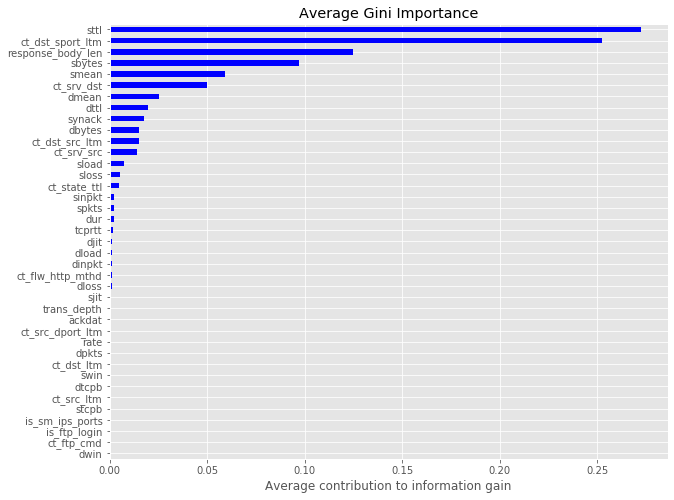

In [55]:
# Plot the feature importance
feat_scores = pd.Series(clf.feature_importances_,
                           index=X.columns)
feat_scores = feat_scores.sort_values()
ax = feat_scores.plot(kind='barh', 
                      figsize=(10,8),
                      color='b')
ax.set_title('Average Gini Importance')
ax.set_xlabel('Average contribution to information gain');
print(feat_scores)

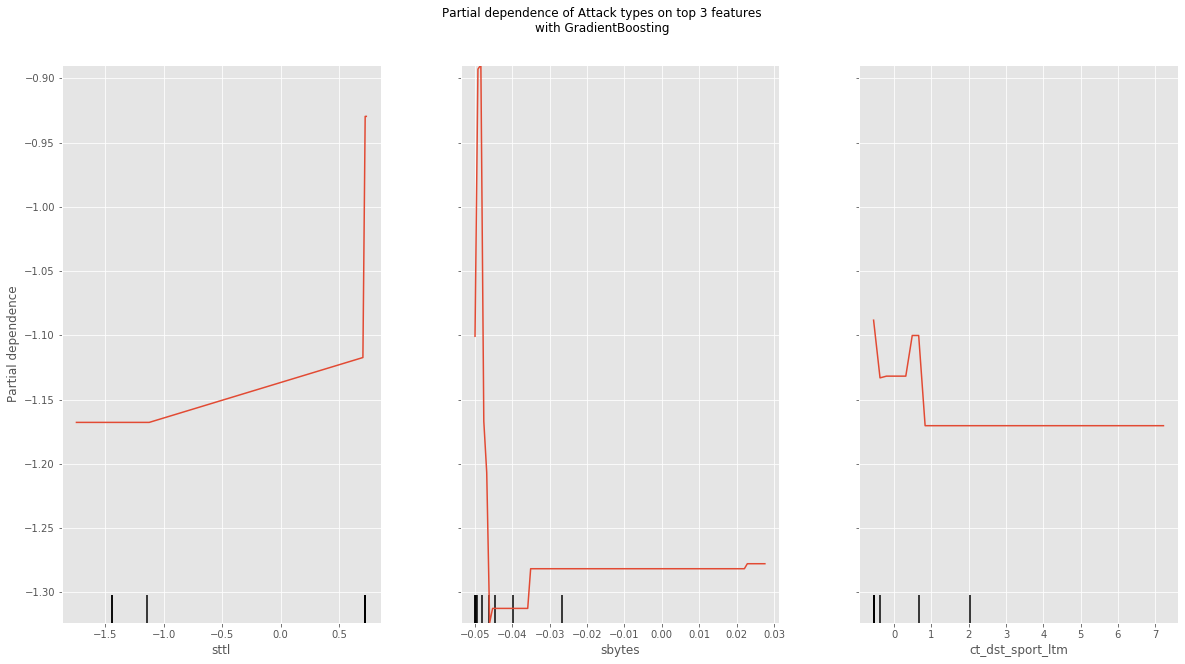

In [56]:
clf_name = models[2][0] # the classifier name
clf = models[2][1] # the classifier itself

features = [6,3,31]
plot_partial_dependence(estimator=clf, X=X_train_transform, 
                        features=features, feature_names=new_cols,
                        target=1)

fig = plt.gcf() # get current figure (gcf)
fig.suptitle("Partial dependence of Attack types on top 3 features\n"
              "with {}".format(clf_name))
fig.set_size_inches(20, 10)
fig.subplots_adjust(hspace=.4, wspace=.25, top=.9)
